# Answering Business Questions using SQL

# Creating Helper Function

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT 
        name,
        type 
    FROM sqlite_master 
    WHERE type IN ("table","view");'''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

新しいレコードレーベルと契約をし、以下の４つのアルバムのうち、３つをストアに加えることになった。
1. Regal / Hip-Hop
2. Red Tone / Punk
3. Meteor and the Girls / Pop
4. Slim Jim Bites / Blues

このレコードはアメリカ出身のアーティストに特化しており、彼らはアメリカ国内で新しいアルバムを宣伝することを求めている。また、4つのアーティストはそれぞれジャンルが異なる。加えるアルバムを決めるためには、アメリカで人気のあるジャンルを調べる必要がある。

In [2]:
albums_to_purchase = '''
With track_sold_usa AS (
    SELECT 
        il.*
    FROM invoice_line il 
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )
    
SELECT 
    g.name genre,
    COUNT(tsu.quantity) num_sold,
    CAST(COUNT(tsu.quantity) as float) / (
    SELECT COUNT(track_sold_usa.quantity) FROM track_sold_usa
    )  pct_sold
FROM track_sold_usa tsu
INNER JOIN track t ON t.track_id = tsu.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
'''
run_query(albums_to_purchase)

,genre,num_sold,pct_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


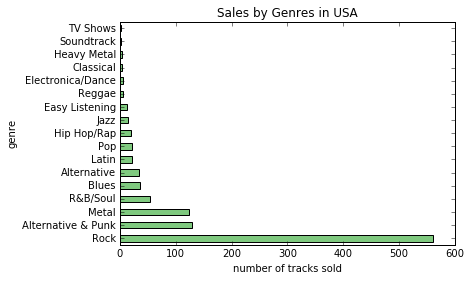

In [3]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre",inplace=True,drop=True)

genre_sales_usa["num_sold"].plot.barh(
    title = "Sales by Genres in USA",
    colormap = "Accent"
    
    )
plt.xlabel("number of tracks sold")

plt.show()

USAにおけるジャンル別のトラック売上枚数から、
* Red Tone(Punk)
* slim Jim Bites(Blues)
* Meteor and the Girls(Pop)

の３組のアーティストのアルバムを加えるべきだと考えられる。ただし、Blues、Popはそれぞれ全体の約3.5%,約2.1%を占めるに過ぎない。対して、Rockは全体の半分を占めているため、レーベルのリストに該当するものはないが、Rock（または約12%を占めるMetal）に分類されるアーティストのアルバムを加えることを提案してみることは無駄ではないであろう。

# Analyzing Employee Sales Performance

In [4]:
employee_sales_performance = '''
WIth employee_total_sales AS 
    (
    SELECT
        support_rep_id,
        SUM(total) total_sales
    FROM customer c 
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    )
    
SELECT 
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    ets.total_sales total_sales
FROM employee e
INNER JOIN employee_total_sales ets 
ON ets.support_rep_id = e.employee_id
ORDER BY 3 
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Steve Johnson,2017-10-17 00:00:00,1393.92
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Jane Peacock,2017-04-01 00:00:00,1731.51


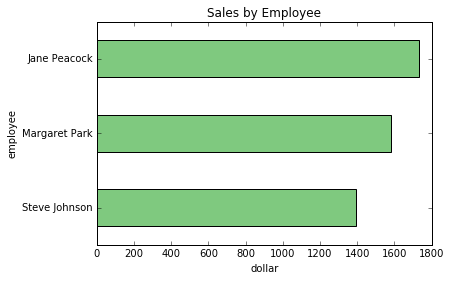

In [5]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee",inplace=True,drop=True)

employee_sales["total_sales"].plot.barh(
    title = "Sales by Employee",
    colormap = "Accent",
    legend = False
    )
plt.xlabel("dollar")

plt.show()

従業員の売上は雇用期間と関係があるようだ。

# Analyzing Sales by Country

Write a query that collates data on purchases from different countries.
Where a country has only one customer, collect them into an "Other" group.
The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.
For each country, include:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [6]:
sales_by_country = '''
WITH country_or_other AS
(
    SELECT
        c.customer_id,
        CASE
            WHEN (SELECT COUNT(*) FROM customer
                  WHERE country = c.country) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    
)

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT 
        country,
        COUNT(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / COUNT(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY 1
    ORDER BY sort ASC, total_sales DESC
    );
    '''
run_query(sales_by_country)    

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Visualizing Sales by Country

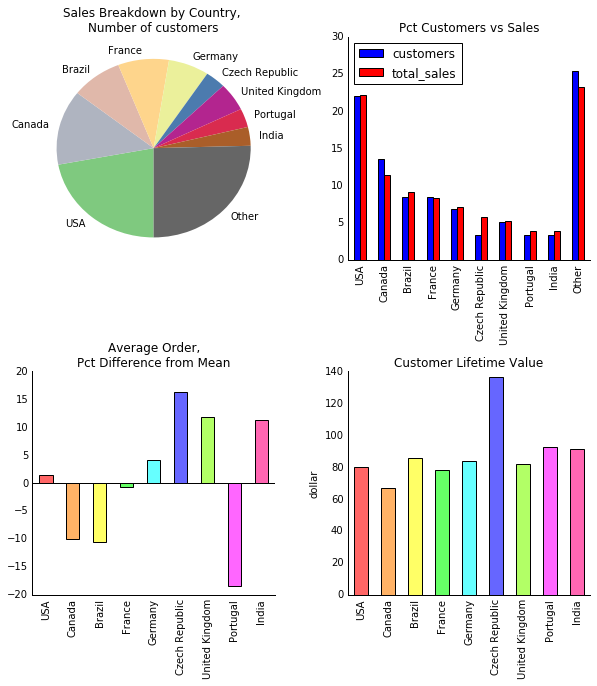

In [8]:
from matplotlib import cm

country_sales_data = run_query(sales_by_country)
country_sales_data.set_index("country", inplace=True, drop=True)
colorlist = ["#FF6666","#FFB266","#FFFF66","#66FF66","#66FFFF","#6666FF","#B2FF66","#FF66FF","#FF66B2"]

fig , ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=.5, wspace=.3)

#top left
sales_breakdown = country_sales_data["customers"].copy().rename("")
sales_breakdown.plot.pie(
    ax = ax1,
    title = "Sales Breakdown by Country, \nNumber of customers",
    startangle = -90,
    counterclock = False,
    colormap = cm.Accent,
    fontsize = 10,
    wedgeprops={'linewidth':0}
)

#top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollar = country_sales_data[cvd_cols].copy()
custs_vs_dollar.index.name = ""
for col in cvd_cols:
    custs_vs_dollar[col] /= custs_vs_dollar[col].sum() / 100 
    
custs_vs_dollar.plot.bar(
    ax = ax2,
    title = "Pct Customers vs Sales",
    colormap = cm.bwr
    )
ax2.tick_params(bottom=False,left=False,top=False,right=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#bottom left
avg_order = country_sales_data["average_order"].copy()
avg_order.index.name = ""
avg_order_mean = avg_order.sum() / len(avg_order)
avg_order_diff_mean_pct = (avg_order - avg_order_mean) / avg_order_mean * 100
avg_order_diff_mean_pct.drop("Other", inplace=True)

avg_order_diff_mean_pct.plot.bar(
    ax = ax3,
    title = "Average Order,\nPct Difference from Mean",
    color = colorlist
)
ax3.axhline(0, color="k")
ax3.tick_params(bottom=False,left=False,top=False,right=False)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

#bottom right
ltv = country_sales_data["customer_lifetime_value"].copy()
ltv.index.name = ""
ltv.drop("Other", inplace=True)

ltv.plot.bar(
    ax = ax4,
    title = "Customer Lifetime Value",
    color =colorlist
)
ax4.set_ylabel("dollar")
ax4.tick_params(bottom=False,left=False,top=False,right=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

以上のデータより、次にあげる３か国にビジネスチャンスがあると考えられる：
* Csech Republic
* United Kingdom
* India

ただし、これらの国のサンプル数は十分ではないため、たちまち大規模なマーケティングキャンペーンを行うべきではない。まずは小規模のキャンペーンを実施し、信用にたる顧客データ数を収集、分析したのちに改めてマーケティングについて議論すべきである。

# Albums vs Individual Tracks

経営陣は経費節減のために各レコード会社から、アルバムに収録されている全トラックを販売する権利を得る代わりに、アルバムの中で最も人気のある数曲のみの権利を得る戦略を考えている。

この戦略の効果を分析する。

In [13]:
q1 = '''
SELECT * FROM invoice_line ORDER BY invoice_id, track_id LIMIT 20
'''
run_query(q1)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1
2,3,1,1160,0.99,1
3,4,1,1161,0.99,1
4,5,1,1162,0.99,1
5,6,1,1163,0.99,1
6,7,1,1164,0.99,1
7,8,1,1165,0.99,1
8,9,1,1166,0.99,1
9,10,1,1167,0.99,1


In [42]:
q1 = '''
WITH invoice_first_track AS
(
SELECT 
    il.invoice_id invoice_id,
    MIN(il.track_id) first_track_id
FROM invoice_line il
GROUP BY 1
)

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoice,
    CAST(COUNT(invoice_id) as FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM
(SELECT
    ift.*,
    CASE
        WHEN 
            (
            SELECT t.track_id FROM track t
            WHERE t.album_id  = (SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.first_track_id)
            
            
            EXCEPT
            
            
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            ) IS NULL
        AND
            (
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            
            
            EXCEPT
            
            
            SELECT t.track_id FROM track t
            WHERE t.album_id  = (SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ift.first_track_id)
            ) IS NULL
        THEN "yes"
        ELSE "no"
    END AS "album_purchase"
FROM invoice_first_track ift
) GROUP BY album_purchase
'''
           
run_query(q1)

,album_purchase,number_of_invoice,percent
0,no,500,0.814332
1,yes,114,0.185668


以上の分析から、アルバム購入が購入履歴のうち18.6%を占めている。収益のおよそ5分の1を失う可能性があるため、経営陣の戦略は実施すべきではない。